# **Riemannian synth data generation PoC**

In [ ]:
dataset_name = 'AppliancesEnergy'

In [ ]:
from fedot_ind.tools.loader import DataLoader

train_data, test_data = DataLoader(dataset_name=dataset_name).load_data()

INFO:datasets:PyTorch version 2.2.2 available.


2024-10-14 11:02:01,498 - PyTorch version 2.2.2 available.


INFO:datasets:Polars version 1.7.1 available.


2024-10-14 11:02:01,507 - Polars version 1.7.1 available.


INFO:datasets:TensorFlow version 2.17.0 available.


2024-10-14 11:02:01,513 - TensorFlow version 2.17.0 available.


INFO:datasets:JAX version 0.4.33 available.


2024-10-14 11:02:01,519 - JAX version 0.4.33 available.


INFO:DataLoader:Reading data from /usr/local/lib/python3.10/dist-packages/fedot_ind/data/AppliancesEnergy


2024-10-14 11:02:01,954 - Reading data from /usr/local/lib/python3.10/dist-packages/fedot_ind/data/AppliancesEnergy


ERROR:DataLoader:Data not found in /usr/local/lib/python3.10/dist-packages/fedot_ind/data/AppliancesEnergy


2024-10-14 11:02:01,960 - Data not found in /usr/local/lib/python3.10/dist-packages/fedot_ind/data/AppliancesEnergy


INFO:DataLoader:Downloading AppliancesEnergy from UCR archive...


2024-10-14 11:02:01,964 - Downloading AppliancesEnergy from UCR archive...


INFO:DataLoader:AppliancesEnergy data downloaded. Unpacking...


2024-10-14 11:02:03,524 - AppliancesEnergy data downloaded. Unpacking...


INFO:DataLoader:Reading data from /usr/local/lib/python3.10/dist-packages/temp_cache/temp_data/AppliancesEnergy


2024-10-14 11:02:03,529 - Reading data from /usr/local/lib/python3.10/dist-packages/temp_cache/temp_data/AppliancesEnergy


INFO:DataLoader:Saving AppliancesEnergy data files to /usr/local/lib/python3.10/dist-packages/fedot_ind/data/AppliancesEnergy


2024-10-14 11:02:04,051 - Saving AppliancesEnergy data files to /usr/local/lib/python3.10/dist-packages/fedot_ind/data/AppliancesEnergy


INFO:DataLoader:Data read successfully from local folder


2024-10-14 11:02:04,060 - Data read successfully from local folder


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.graph_objects as go

from tensorly import tensor, tt_to_tensor, norm
from typing import Optional, Sequence
from sklearn.decomposition import PCA
from pyriemann.embedding import SpectralEmbedding
from pyriemann.estimation import Covariances, Shrinkage


def plot_sns_heatmap(matrix):
    fig, axes = plt.subplots(1, 1, figsize=(10, 6))
    sns.heatmap(matrix, cmap="crest", ax=axes)
    plt.tight_layout()
    plt.show()


def plot_multivariate_data_comparison(features: np.ndarray,
                                      new_features: np.ndarray,
                                      sample_id: int = 0,
                                      channel_ids: Optional[Sequence[int]] = None,
                                      show_multiplot: bool = True) -> None:
    n_samples, n_channels, ts_length = features.shape
    sample, new_sample = features[sample_id], new_features[sample_id]
    channel_ids = range(n_channels) if channel_ids is None else channel_ids
    fig = plt.figure(figsize=(15, 10))
    plt.title(f'Sample {sample_id}')

    for i, channel_id in enumerate(channel_ids):
        if show_multiplot:
            plt.subplot(len(channel_ids), 1, i + 1)
        for cmap, label, data in zip([plt.get_cmap('Blues'), plt.get_cmap('Reds')], ['orig', 'synth'], [sample, new_sample]):
            plt.plot(data[channel_id], color=cmap(np.random.randint(50, 200)), label=f'{label} - {channel_id}')

    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_pca_comparison(features: np.ndarray, new_features: np.ndarray) -> None:
    pca = PCA(n_components=3)
    fig = go.Figure()
    for label, features_arr in zip(['original data', 'synthetical data'], [features, new_features]):
        features_tensor = tensor(features_arr)
        # rank = [1, 100, 100, 1]
        # tt_decomp = tensor_train(features_tensor, rank=rank)
        # reconstructed_tensor = tt_to_tensor(tt_decomp)
        # print(norm(features_tensor - reconstructed_tensor, 2))
        # flattened_data = reconstructed_tensor.reshape(reconstructed_tensor.shape[0], -1)
        flattened_data = features_tensor.reshape(features_tensor.shape[0], -1)
        reduced_data = pca.fit_transform(flattened_data)
        df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2', 'PC3'])
        fig.add_trace(go.Scatter3d(x=df['PC1'], y=df['PC2'], z=df['PC3'],
                                   mode='markers', marker=dict(size=5), name=label))
        fig.update_layout(scene=dict(xaxis_title='PC1',
                                     yaxis_title='PC2',
                                     zaxis_title='PC3'),
                          title='Comparison of pca decompositions of old and transformed features')
    fig.show()


def plot_spectral_embeddings_comparison(features: np.ndarray,
                                        new_features: np.ndarray,
                                        spd_space: Covariances,
                                        shrinkage: Shrinkage) -> None:
    lapl = SpectralEmbedding(metric='riemann', n_components=3)
    fig = go.Figure()
    for label, features_arr in zip(['original data', 'synthetical data'], [features, new_features]):
        covmats = spd_space.transform(features_arr)
        covmats = shrinkage.transform(covmats)
        reduced_data = lapl.fit_transform(X=covmats)
        df = pd.DataFrame(reduced_data, columns=['EMB1', 'EMB2', 'EMB3'])
        fig.add_trace(go.Scatter3d(x=df['EMB1'], y=df['EMB2'], z=df['EMB3'],
                                   mode='markers', marker=dict(size=5), name=label))
        fig.update_layout(scene=dict(xaxis_title='EMB1',
                                     yaxis_title='EMB2',
                                     zaxis_title='EMB3'),
                          title='Comparison of spectral embeddings of old and transformed features')
    fig.show()

In [ ]:
features, target = test_data

In [ ]:
features.shape, target.shape

((42, 24, 144), (42,))

In [ ]:
from pyriemann.estimation import Covariances, Shrinkage
from pyriemann.tangentspace import TangentSpace

spd_space = Covariances(estimator='scm')
tangent_space = TangentSpace(metric='riemann')
shrinkage = Shrinkage()

In [ ]:
covmats = spd_space.fit_transform(features, target)
spd_mats = shrinkage.fit_transform(covmats)
ref_point = tangent_space.transform(spd_mats)

In [ ]:
covmats.shape

(42, 24, 24)

In [ ]:
spd_mats.shape

(42, 24, 24)

In [ ]:
ref_point.shape

(42, 300)

In [ ]:
from scipy.linalg import svd, norm, eigvals, cholesky, LinAlgError

def get_nearest_positive_defined(matrix):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """
    B = (matrix + matrix.T) / 2
    _, s, V = svd(B)
    A2 = (B + np.dot(V.T, np.dot(np.diag(s), V))) / 2
    A3 = (A2 + A2.T) / 2
    if is_poisitive_defined(A3):
        return A3
    spacing = np.spacing(norm(matrix))
    # The above is different from [1]. It appears that MATLAB's `chol` Cholesky
    # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
    # Numpy's will not. So where [1] uses `eps(mineig)` (where `eps` is Matlab
    # for `np.spacing`), we use the above definition. CAVEAT: our `spacing`
    # will be much larger than [1]'s `eps(mineig)`, since `mineig` is usually on
    # the order of 1e-16, and `eps(1e-16)` is on the order of 1e-34, whereas
    # `spacing` will, for Gaussian random matrixes of small dimension, be on
    # othe order of 1e-16. In practice, both ways converge, as the unit test
    # below suggests.
    I = np.eye(matrix.shape[0])
    k = 1
    while not is_poisitive_defined(A3):
        mineig = np.min(np.real(eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1
    return A3


def is_poisitive_defined(B):
    try:
        _ = cholesky(B)
        return True
    except LinAlgError:
        return False

In [ ]:
import numpy as np
from scipy.linalg import logm, expm

# apply log to a set of SPD covmats, transforming each sample to a tangent space
tangent_mats = np.array(list(map(logm, spd_mats)))

# tangent_spd_mats = np.array(list(map(get_nearest_positive_defined, tangent_mats)))

In [ ]:
tangent_mats.shape

(42, 24, 24)

## Euclidian distances on tangent samples

In [ ]:
from pyriemann.utils.distance import distance
from functools import partial
from itertools import product

distance_euclidian = partial(distance, metric='euclid')

tangent_distances = np.array([distance_euclidian(a, b) for a, b in product(tangent_mats, tangent_mats)])
tangent_distances = tangent_distances.reshape(tangent_mats.shape[0], -1)
tangent_distances.shape, np.isnan(tangent_distances).sum()

((42, 42), 0)

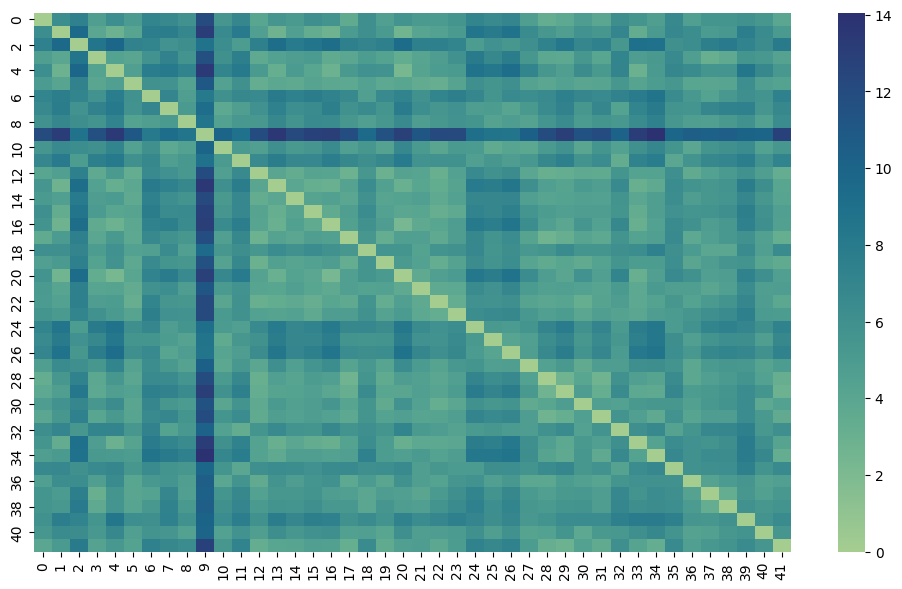

In [ ]:
plot_sns_heatmap(tangent_distances)

In [ ]:
from typing import Callable

def mutate_and_get_distances_diff(mutation_func: Callable, matrices: np.ndarray):
    distances = np.array([distance_euclidian(a, b) for a, b in product(matrices, matrices)])
    distances = distances.reshape(matrices.shape[0], -1)

    new_matrices = mutation_func(matrices)
    new_distances = np.array([distance_euclidian(a, b) for a, b in product(new_matrices, new_matrices)])
    new_distances = new_distances.reshape(new_matrices.shape[0], -1)

    return new_matrices, new_distances - distances

## Orthogonal matrices transformation

In [ ]:
from scipy.stats import ortho_group

def apply_orthogonal_matrix(matrices: np.ndarray) -> np.ndarray:
    dimension = matrices[0].shape[0]
    ortho_matrix = ortho_group.rvs(dim=dimension)
    return np.array([ortho_matrix @ matrix for matrix in matrices])

In [ ]:
ortho_tangent_mats, ortho_distances_diff = mutate_and_get_distances_diff(apply_orthogonal_matrix, tangent_mats)

In [ ]:
assert ortho_distances_diff.sum() < 1e-10

In [ ]:
# inverse transformation from tangent space
ortho_covmats = np.array(list(map(expm, ortho_tangent_mats)))

In [ ]:
ortho_covmats.shape

(42, 24, 24)

In [ ]:
from scipy.stats import multivariate_normal

# new features from new covmats
ortho_samples = np.zeros(features.shape)

for i, ortho_matrix in enumerate(ortho_covmats):
    cov_matrix = get_nearest_positive_defined(ortho_matrix)

    original_sample_means = np.mean(features[i], axis=1)
    num_channels, ts_length = features[i].shape

    ortho_samples[i] = multivariate_normal.rvs(mean=original_sample_means,
                                               cov=cov_matrix,
                                               size=ts_length).T

In [ ]:
ortho_samples.shape

(42, 24, 144)

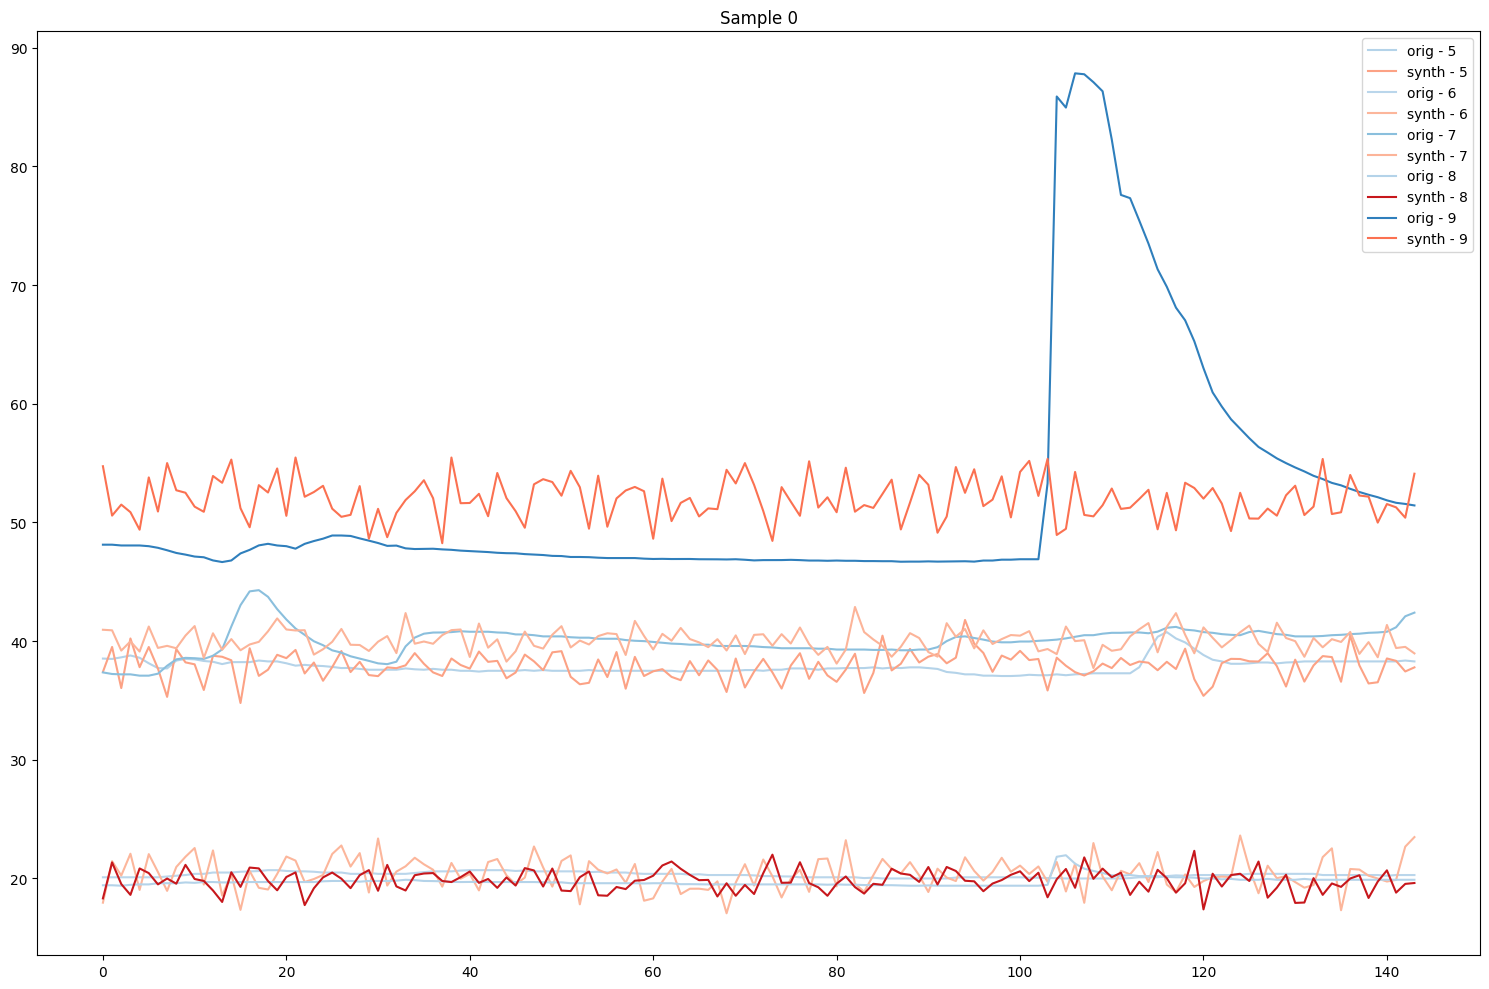

In [ ]:
plot_multivariate_data_comparison(features, ortho_samples, sample_id=0, channel_ids=range(5, 10), show_multiplot=False)

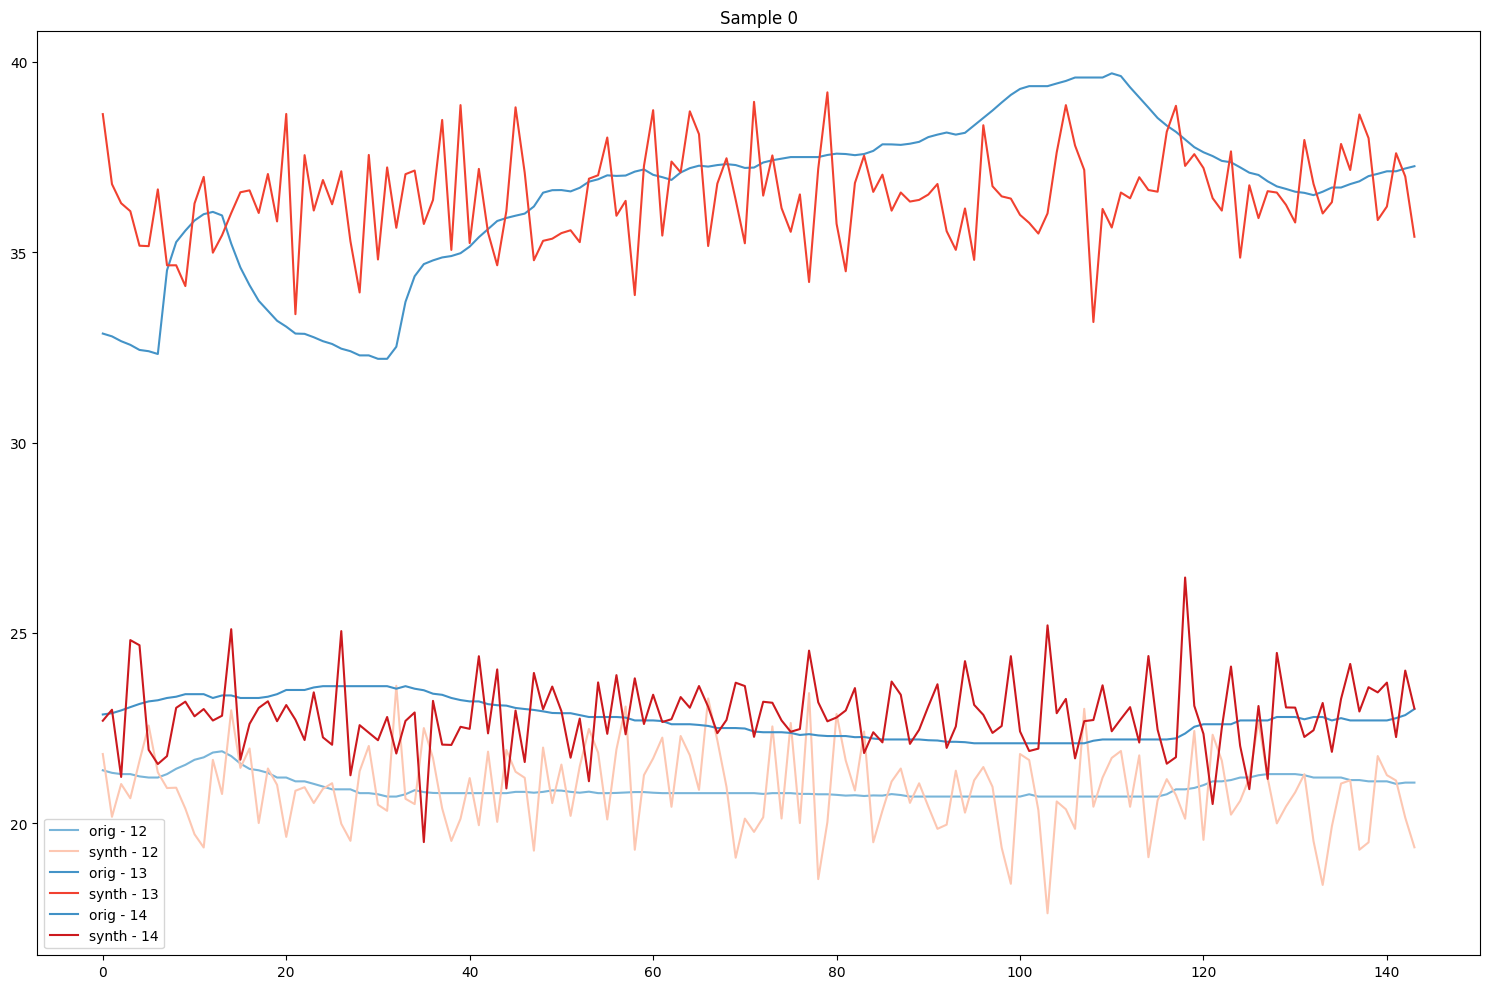

In [ ]:
plot_multivariate_data_comparison(features, ortho_samples, sample_id=0, channel_ids=range(12, 15), show_multiplot=False)

In [ ]:
plot_pca_comparison(features, ortho_samples)

In [ ]:
plot_spectral_embeddings_comparison(features, ortho_samples, spd_space, shrinkage)

In [ ]:
from fedot_ind.core.architecture.pipelines.abstract_pipeline import ApiTemplate

api_config = dict(problem='regression',
                  metric='rmse',
                  timeout=10,
                  n_jobs=-1,
                  logging_level=20)
metric_names = ('r2', 'rmse', 'mae')
api_template = ApiTemplate(api_config=api_config, metric_list=metric_names)

In [ ]:
result_dict = api_template.eval(dataset=dataset_name, finetune=False)
print(result_dict['metrics'])

INFO:DataLoader:Reading data from /usr/local/lib/python3.10/dist-packages/fedot_ind/data/AppliancesEnergy


2024-10-14 11:21:58,057 - Reading data from /usr/local/lib/python3.10/dist-packages/fedot_ind/data/AppliancesEnergy


INFO:DataLoader:Data read successfully from local folder


2024-10-14 11:21:58,729 - Data read successfully from local folder


INFO:FedotIndustrialAPI:Initialising experiment setup


2024-10-14 11:21:58,762 - Initialising experiment setup


INFO:FedotIndustrialAPI:Initialising Industrial Repository


2024-10-14 11:21:58,816 - Initialising Industrial Repository


INFO:FedotIndustrialAPI:Initialising Dask Server


2024-10-14 11:21:58,821 - Initialising Dask Server


INFO:distributed.scheduler:State start


Creating Dask Server
2024-10-14 11:21:58,863 - State start


INFO:distributed.scheduler:  Scheduler at: inproc://172.28.0.12/925/9


2024-10-14 11:21:58,875 -   Scheduler at: inproc://172.28.0.12/925/9


INFO:distributed.scheduler:  dashboard at:  http://172.28.0.12:37545/status


2024-10-14 11:21:58,880 -   dashboard at:  http://172.28.0.12:37545/status


INFO:distributed.scheduler:Registering Worker plugin shuffle


2024-10-14 11:21:58,886 - Registering Worker plugin shuffle


INFO:distributed.worker:      Start worker at: inproc://172.28.0.12/925/12


2024-10-14 11:21:58,901 -       Start worker at: inproc://172.28.0.12/925/12


INFO:distributed.worker:         Listening to:          inproc172.28.0.12


2024-10-14 11:21:58,908 -          Listening to:          inproc172.28.0.12


INFO:distributed.worker:          Worker name:                          0


2024-10-14 11:21:58,914 -           Worker name:                          0


INFO:distributed.worker:         dashboard at:          172.28.0.12:43711


2024-10-14 11:21:58,920 -          dashboard at:          172.28.0.12:43711


INFO:distributed.worker:Waiting to connect to: inproc://172.28.0.12/925/9


2024-10-14 11:21:58,923 - Waiting to connect to: inproc://172.28.0.12/925/9


INFO:distributed.worker:-------------------------------------------------


2024-10-14 11:21:58,926 - -------------------------------------------------


INFO:distributed.worker:              Threads:                          2


2024-10-14 11:21:58,928 -               Threads:                          2


INFO:distributed.worker:               Memory:                  12.67 GiB


2024-10-14 11:21:58,931 -                Memory:                  12.67 GiB


INFO:distributed.worker:      Local Directory: /tmp/dask-scratch-space/worker-8mz9223y


2024-10-14 11:21:58,933 -       Local Directory: /tmp/dask-scratch-space/worker-8mz9223y


INFO:distributed.worker:-------------------------------------------------


2024-10-14 11:21:58,936 - -------------------------------------------------


INFO:distributed.scheduler:Register worker <WorkerState 'inproc://172.28.0.12/925/12', name: 0, status: init, memory: 0, processing: 0>


2024-10-14 11:21:58,943 - Register worker <WorkerState 'inproc://172.28.0.12/925/12', name: 0, status: init, memory: 0, processing: 0>


INFO:distributed.scheduler:Starting worker compute stream, inproc://172.28.0.12/925/12


2024-10-14 11:21:58,947 - Starting worker compute stream, inproc://172.28.0.12/925/12


INFO:distributed.core:Starting established connection to inproc://172.28.0.12/925/13


2024-10-14 11:21:58,949 - Starting established connection to inproc://172.28.0.12/925/13


INFO:distributed.worker:Starting Worker plugin shuffle


2024-10-14 11:21:58,952 - Starting Worker plugin shuffle


INFO:distributed.worker:        Registered to: inproc://172.28.0.12/925/9


2024-10-14 11:21:58,956 -         Registered to: inproc://172.28.0.12/925/9


INFO:distributed.worker:-------------------------------------------------


2024-10-14 11:21:58,959 - -------------------------------------------------


INFO:distributed.core:Starting established connection to inproc://172.28.0.12/925/9


2024-10-14 11:21:58,962 - Starting established connection to inproc://172.28.0.12/925/9


INFO:distributed.scheduler:Receive client connection: Client-86f555a2-8a1e-11ef-839d-0242ac1c000c


2024-10-14 11:21:58,970 - Receive client connection: Client-86f555a2-8a1e-11ef-839d-0242ac1c000c


INFO:distributed.core:Starting established connection to inproc://172.28.0.12/925/14


2024-10-14 11:21:58,978 - Starting established connection to inproc://172.28.0.12/925/14


INFO:FedotIndustrialAPI:LinK Dask Server - http://172.28.0.12:37545/status


2024-10-14 11:21:58,985 - LinK Dask Server - http://172.28.0.12:37545/status


INFO:FedotIndustrialAPI:Initialising solver


2024-10-14 11:21:58,987 - Initialising solver


INFO:root:AssumptionsHandler - Initial pipeline fitting started


2024-10-14 11:21:59,103 - AssumptionsHandler - Initial pipeline fitting started


INFO:root:AssumptionsHandler - Initial pipeline was fitted successfully


2024-10-14 11:27:48,949 - AssumptionsHandler - Initial pipeline was fitted successfully


INFO:root:AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 48.4 MiB, max: 95.4 MiB


2024-10-14 11:27:48,962 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 48.4 MiB, max: 95.4 MiB


CRITICAL:root:ApiComposer - Initial pipeline was fitted in 1049.8 sec.


2024-10-14 11:27:48,976 - ApiComposer - Initial pipeline was fitted in 1049.8 sec.


CRITICAL:root:AssumptionsHandler - Preset was changed to fast_train due to fit time estimation for initial model.


2024-10-14 11:27:48,986 - AssumptionsHandler - Preset was changed to fast_train due to fit time estimation for initial model.


CRITICAL:root:ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 10 min. Set of candidate models: ['xgbreg', 'sgdr', 'treg', 'ridge', 'lasso', 'dtreg', 'lgbmreg', 'catboostreg', 'inception_model', 'resnet_model', 'channel_filtration', 'eigen_basis', 'wavelet_basis', 'fourier_basis', 'quantile_extractor', 'minirocket_extractor', 'scaling', 'normalization', 'simple_imputation', 'kernel_pca'].


2024-10-14 11:27:49,016 - ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 10 min. Set of candidate models: ['xgbreg', 'sgdr', 'treg', 'ridge', 'lasso', 'dtreg', 'lgbmreg', 'catboostreg', 'inception_model', 'resnet_model', 'channel_filtration', 'eigen_basis', 'wavelet_basis', 'fourier_basis', 'quantile_extractor', 'minirocket_extractor', 'scaling', 'normalization', 'simple_imputation', 'kernel_pca'].


CRITICAL:root:ApiComposer - Timeout is too small for composing and is skipped because fit_time is 1049.759553 sec.


2024-10-14 11:27:49,066 - ApiComposer - Timeout is too small for composing and is skipped because fit_time is 1049.759553 sec.


INFO:root:DataSourceSplitter - Stratificated splitting of data is disabled.


2024-10-14 11:27:49,084 - DataSourceSplitter - Stratificated splitting of data is disabled.


INFO:root:DataSourceSplitter - Hold out validation is applied.


2024-10-14 11:27:49,097 - DataSourceSplitter - Hold out validation is applied.


CRITICAL:root:ApiComposer - Hyperparameters tuning started with 4 min. timeout


2024-10-14 11:27:49,122 - ApiComposer - Hyperparameters tuning started with 4 min. timeout


INFO:root:SimultaneousTuner - Hyperparameters optimization start: estimation of metric for initial graph


2024-10-14 11:27:49,136 - SimultaneousTuner - Hyperparameters optimization start: estimation of metric for initial graph


CRITICAL:root:SimultaneousTuner - Initial graph: {'depth': 2, 'length': 2, 'nodes': [treg, quantile_extractor]}
treg - {}
quantile_extractor - {'window_size': 10, 'stride': 1, 'add_global_features': True} 
Initial metric: [4.41]


2024-10-14 11:32:14,387 - SimultaneousTuner - Initial graph: {'depth': 2, 'length': 2, 'nodes': [treg, quantile_extractor]}
treg - {}
quantile_extractor - {'window_size': 10, 'stride': 1, 'add_global_features': True} 
Initial metric: [4.41]


CRITICAL:root:SimultaneousTuner - Tunner stopped after initial assumption due to the lack of time


2024-10-14 11:32:14,406 - SimultaneousTuner - Tunner stopped after initial assumption due to the lack of time


INFO:root:SimultaneousTuner - Hyperparameters optimization finished


2024-10-14 11:32:14,418 - SimultaneousTuner - Hyperparameters optimization finished


INFO:root:SimultaneousTuner - Return init graph due to the fact that obtained metric 4.410 worse than initial (+ 0.05% deviation) 4.408


2024-10-14 11:37:05,302 - SimultaneousTuner - Return init graph due to the fact that obtained metric 4.410 worse than initial (+ 0.05% deviation) 4.408


CRITICAL:root:SimultaneousTuner - Final graph: {'depth': 2, 'length': 2, 'nodes': [treg, quantile_extractor]}
treg - {}
quantile_extractor - {'window_size': 10, 'stride': 1, 'add_global_features': True}


2024-10-14 11:37:05,325 - SimultaneousTuner - Final graph: {'depth': 2, 'length': 2, 'nodes': [treg, quantile_extractor]}
treg - {}
quantile_extractor - {'window_size': 10, 'stride': 1, 'add_global_features': True}


CRITICAL:root:SimultaneousTuner - Final metric: 4.410


2024-10-14 11:37:05,334 - SimultaneousTuner - Final metric: 4.410


CRITICAL:root:ApiComposer - Hyperparameters tuning finished


2024-10-14 11:37:05,347 - ApiComposer - Hyperparameters tuning finished


CRITICAL:root:ApiComposer - Model generation finished


2024-10-14 11:37:06,358 - ApiComposer - Model generation finished


CRITICAL:root:FEDOT logger - Final pipeline was fitted


2024-10-14 11:41:40,456 - FEDOT logger - Final pipeline was fitted


CRITICAL:root:FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [treg, quantile_extractor]}
treg - {}
quantile_extractor - {'window_size': 10, 'stride': 1, 'add_global_features': True}


2024-10-14 11:41:40,471 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [treg, quantile_extractor]}
treg - {}
quantile_extractor - {'window_size': 10, 'stride': 1, 'add_global_features': True}


INFO:root:MemoryAnalytics - Memory consumption for finish in main session: current 97.6 MiB, max: 144.0 MiB


2024-10-14 11:41:40,481 - MemoryAnalytics - Memory consumption for finish in main session: current 97.6 MiB, max: 144.0 MiB


CRITICAL:root:FEDOT logger - Predictions was saved in current directory.


2024-10-14 11:43:32,759 - FEDOT logger - Predictions was saved in current directory.
     r2   rmse    mae
0  0.69  1.914  1.549


In [ ]:
ortho_result_dict = api_template._get_result((ortho_samples, test_data[1]))
print(ortho_result_dict['metrics'])

CRITICAL:root:FEDOT logger - Predictions was saved in current directory.


2024-10-14 11:45:22,867 - FEDOT logger - Predictions was saved in current directory.
      r2   rmse    mae
0 -2.442  6.379  5.801


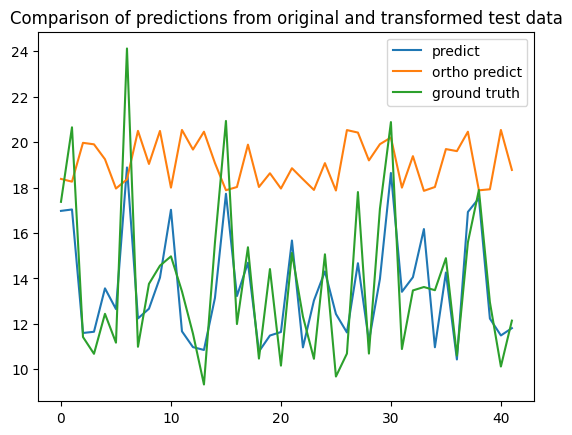

In [ ]:
labels, ortho_labels = result_dict['labels'], ortho_result_dict['labels']
fig, ax = plt.subplots()
ax.plot(labels, label='predict')
ax.plot(ortho_labels, label='ortho predict')
ax.plot(test_data[1], label='ground truth')
ax.legend()
ax.set_title('Comparison of predictions from original and transformed test data')
plt.show()

## Gaussian Noise transformation

In [ ]:
from scipy.stats import ortho_group

def apply_gaussian_noise(matrices: np.ndarray, mean=0, stdev=1e-2) -> np.ndarray:
    return np.array([np.random.normal(mean, stdev, size=matrix.shape) + matrix for matrix in matrices])

In [ ]:
noise_tangent_mats, noise_distances_diff = mutate_and_get_distances_diff(apply_gaussian_noise, tangent_mats)
print(noise_distances_diff.sum())
# inverse transformation from tangent space
noise_covmats = np.array(list(map(expm, noise_tangent_mats)))

20.609867087642805


In [ ]:
from scipy.stats import multivariate_normal

# new features from new covmats
noise_samples = np.zeros(features.shape)

for i, noise_matrix in enumerate(noise_covmats):
    cov_matrix = get_nearest_positive_defined(noise_matrix)

    original_sample_means = np.mean(features[i], axis=1)
    num_channels, ts_length = features[i].shape

    noise_samples[i] = multivariate_normal.rvs(mean=original_sample_means,
                                               cov=cov_matrix,
                                               size=ts_length).T

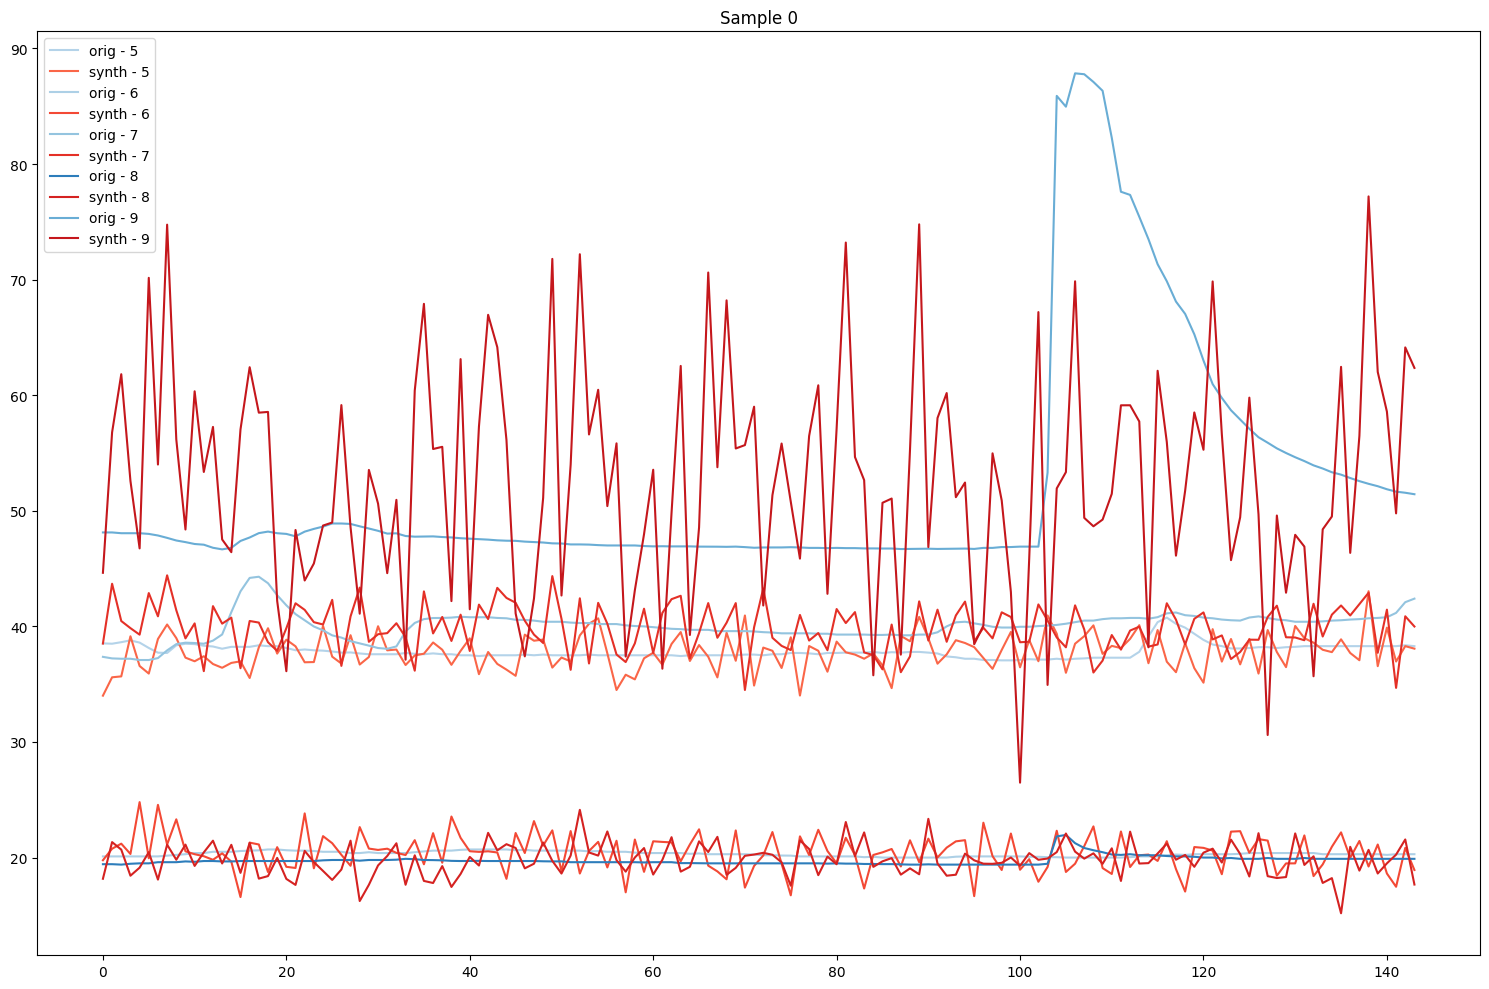

In [ ]:
plot_multivariate_data_comparison(features, noise_samples, sample_id=0, channel_ids=range(5, 10), show_multiplot=False)

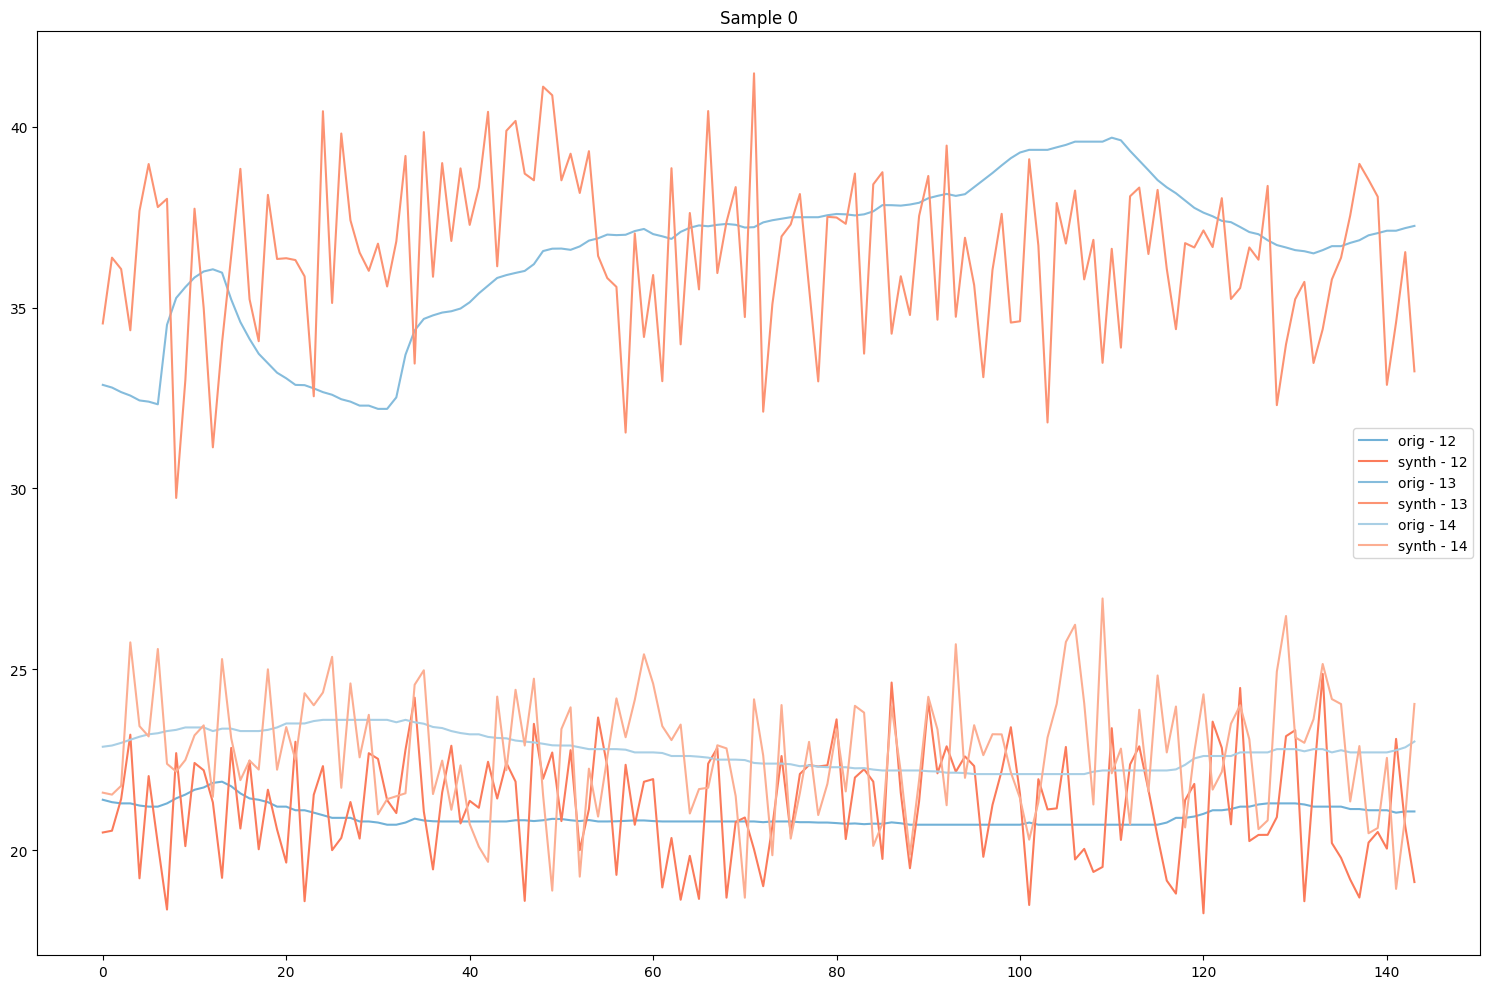

In [ ]:
plot_multivariate_data_comparison(features, noise_samples, sample_id=0, channel_ids=range(12, 15), show_multiplot=False)

In [ ]:
noise_result_dict = api_template._get_result((noise_samples, test_data[1]))
print(result_dict['metrics'])
print(noise_result_dict['metrics'])

CRITICAL:root:FEDOT logger - Predictions was saved in current directory.


2024-10-14 14:23:13,457 - FEDOT logger - Predictions was saved in current directory.
     r2   rmse    mae
0  0.69  1.914  1.549
     r2   rmse    mae
0 -2.55  6.478  5.908


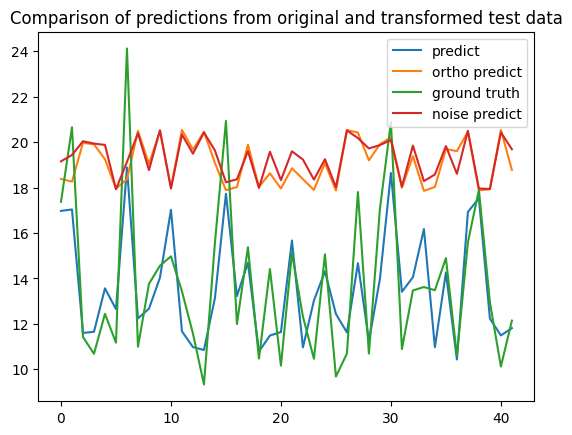

In [ ]:
noise_labels = noise_result_dict['labels']
fig, ax = plt.subplots()
ax.plot(labels, label='predict')
ax.plot(ortho_labels, label='ortho predict')
ax.plot(test_data[1], label='ground truth')
ax.plot(noise_labels, label='noise predict')
ax.legend()
ax.set_title('Comparison of predictions from original and transformed test data')
plt.show()

## Affine transformation (specifically scaling)